In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [34]:
frames = glob.glob('highway/*.jpg')


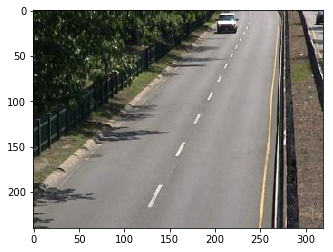

In [35]:
a=plt.imread(frames[1])
plt.imshow(a)

In [36]:
frame = plt.imread(frames[0])
frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])


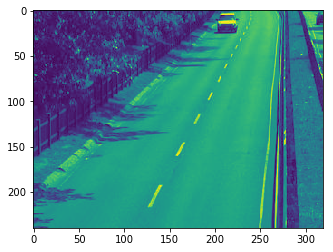

In [37]:
plt.imshow(frame)


In [38]:
np.min(frame)


0.527

In [39]:
shape = frame.shape

In [40]:
shape

(240, 320)

In [41]:
type(frame)

numpy.ndarray

In [42]:
frame

array([[ 60.898,  18.898,  35.898, ...,  66.214,  60.257,  55.887],
       [ 57.898,  29.898,  28.898, ..., 144.926, 139.969, 131.898],
       [ 39.898,  31.898,  19.898, ..., 122.236, 141.681, 156.681],
       ...,
       [140.131, 136.131, 132.131, ...,  86.687,  96.687, 120.687],
       [116.131, 103.131,  91.131, ...,  88.975, 101.975, 111.975],
       [ 91.131,  72.131,  60.131, ..., 103.975, 108.975,  93.975]])

In [43]:
K=4

In [44]:
#out = cv2.VideoWriter('outhighway.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (shape[0],shape[1]))
parameters = np.zeros((shape[0],shape[1],K*2 + K))
alpha = 0.001 #To update weight 
#K gaussians, 1 parameter for sigma, 1 for mu for each of the gaussians and 4 parameters for the weights

In [45]:
import numpy.matlib as nlib
parameters[:,:,8:12]=1/K #Setting initial weights
frame = frame/255.0 #Normalise 1st frame
parameters[:,:,0]=0.0784#20#Standard deviation is one
parameters[:,:,2]=0.0784#20
parameters[:,:,4]=0.0784#20
parameters[:,:,6]=0.0784#20#Standard deviation is one for first frame
frame = plt.imread(frames[0])
parameters[:,:,1]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.62745#frame#Mean value is just pixel value for first frame
frame = plt.imread(frames[1])
parameters[:,:,3]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.18#frame
frame = plt.imread(frames[2])
parameters[:,:,5]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.144#frame
frame = plt.imread(frames[3])
parameters[:,:,7]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.5806274509803921#frame

In [46]:
#Gaussian function
def Gaussian(mu,sigmasquare,x):
    #mu and x are 1*1
    #a = np.transpose(x-mu)
    #siginv = (1/sigmasquare)*np.array([[1,0,0],[0,1,0],[0,0,1]])
    #b = np.matmul(a,siginv)
    #b = np.matmul(b,x-mu)
    b = (x-mu)*(x-mu)
    b = b*(-1/2)
    b = b/sigmasquare
    b = np.exp(b)
    b = b/np.power(2*22/7,0.5)
    sigma = np.sqrt(sigmasquare)
    b = b/(sigma)
    fg=0
    if(x>mu+2.5*sigma):
        fg=1
    if(x<mu-2.5*sigma):
        fg=1
    b = alpha*b
    return b,fg

In [47]:
#out.release()


In [51]:
#Parameter updation and backgroud detection using rest of the frames
def processframes(k):
    #Parameter updation and backgroud detection using rest of the frames
    #while(ret==True):
    l=k+25
    while(k<=l):
        frame = plt.imread(frames[k])
        frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
        frame = frame/255.0
        k=k+1
        foreground = np.zeros((shape[0],shape[1],3))#Full black
        print(k)
        for i in range(shape[0]):
            for j in range(shape[1]):
                #Getting details of current frame with past parameters
                ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
                ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
                ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
                ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
                prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
                prob = prob/alpha
                if(prob>0.5):
                    foreground[i,j,:]=1
                #Updating weights
                if(fg1>=2):
                    parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
                else:
                    parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
                if(fg2>=2):
                    parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
                else:
                    parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
                if(fg3>=2):
                    parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
                else:
                    parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
                if(fg4>=2):
                    parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
                else:
                    parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
                #Updating mu
                parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
                parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
                parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
                parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
                #Updating sigma
                parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
                parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
                parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
                parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])

    plt.imsave(str(k)+'.png',foreground.astype(np.float))
                # Write the frame into the file 'outhighway.avi'
                #foreground = foreground.astype(np.uint8)
                #out.write(foreground)
    return(k)
            

In [52]:
k=processframes(1)#25
k=processframes(k)#50
k=processframes(k)#75
k=processframes(k)#100
k=processframes(k)#125
k=processframes(k)#150
k=processframes(k)#175
k=processframes(k)#200
k=processframes(k)#225
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#300
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#400
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#500
k=processframes(k)#
k=processframes(k)#550

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [53]:
k=processframes(k)#
k=processframes(k)#600
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#

574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823


In [54]:
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#

1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
